In [7]:
import time
import matplotlib.pyplot as plt
import numpy as np

from IPython.display import display, clear_output
import gc
import sys

print("Python executable:", sys.executable)
print("Python version:", sys.version)
import matplotlib
import matplotlib.pyplot as plt

print(matplotlib.__version__)
import math

import numpy as np

import numba
from numba import jit

Python executable: /usr/bin/python3
Python version: 3.11.2 (main, Nov 30 2024, 21:22:50) [GCC 12.2.0]
3.10.1


In [8]:
TOTAL_ITERATION = 10000
VERBOSE1=True
VERBOSE2=False
GC_COLLECT = True

Cs=math.sqrt(1/3)
D=1e-3 #m
L=1 #m

D_nd=50 #100

Yn=D_nd #+1
Xn=200 #int(Yn*L/D)

if(VERBOSE1): print("Ny: {0}".format(Yn))
if(VERBOSE1): print("Nx: {0}".format(Xn))

dx=D/D_nd #old->5*10**(-5)
dy = dx
if(VERBOSE1): print("dx: {0}".format(dx))
#relaxation time tau, should be > 0,5
tau=0.6

dP=1e-2 #Pa
rho_0=1e3 #kg/m^3
p_in=1/3
p_out=p_in-dP
roh_in=p_in/Cs**2
roh_out=p_out/Cs**2
dRho=dP/Cs**2


if(VERBOSE1): 
    print("p_in: {0}".format(p_in))
    print("p_out: {0}".format(p_out))
    print("roh_in: {0}".format(roh_in))
    print("roh_out: {0}".format(roh_out))

nu=2.9e-6 #m^2/s 
dt=Cs**2*(tau-0.5)*(dx**2/nu)

nu_ = Cs**2*(tau-0.5)*(dx**2) * dx
dt_=Cs**2*(tau-0.5)*(dx**2/nu_)

Cs_ = math.sqrt(1/3*(dx**2/dt**2))
if(VERBOSE1): print("dt: {0}".format(dt))

#Poiseuille centerline (max) velocity
U=1/8*(rho_0/nu)*(dP/L)*(D**2)
#U=1.25

Re=D*U/nu
Ma=U/Cs 
Kn=U*D/nu
if(VERBOSE1): 
    print("U: {0}".format(U))
    print("Re: {0}".format(Re))
    print("Ma: {0}".format(Ma))
    print("Kn: {0}".format(Kn))

#we need Cl, Croh, Ct

# 1. Conversion factor Cl for length
Cl=dx #freely chosen
dx_nd=dx/Cl
if(VERBOSE1): 
    print("Cl: {0}".format(Cl))
    print("dx_nd: {0}".format(dx_nd))

#2. Conversion factor Croh for density
Croh=rho_0
roh_nd = rho_0/Croh
if(VERBOSE1): 
    print("Croh: {0}".format(Croh))
    print("roh_nd: {0}".format(roh_nd))

#3. Conversion factor Ct for time
Ct=dt
dt_nd = dt/Ct
if(VERBOSE1): 
    print("Ct: {0}".format(Ct))
    print("dt_nd: {0}".format(dt_nd))

#4. Conversion factor Cu for velocity
Cu=Cl/Ct
U_nd = U/Cu #-> limit U_nd=0.1
U_nd=0.1

if(VERBOSE1): 
    print("Cu: {0}".format(Cu))
    print("U_nd: {0}".format(U_nd))

#5. Conversion factor CF for Force
CF=Croh*Cl**4*Ct**(-2)
if(VERBOSE1): print("CF: {0}".format(CF))

#6. Conversion factor Cf for frequency
Cf=1/Ct
if(VERBOSE1): print("Cf: {0}".format(Cf))

#change nu_nd in order to achieve U_nd=0,1
nu_nd=((D_nd*U_nd)/(D*U))*nu
if(VERBOSE1): print("nu_nd: {0}".format(nu_nd))

tau_nd=(nu_nd/Cs**2)+1./2
if(VERBOSE1): print("tau_nd: {0}".format(tau_nd))
omega = dt/tau
if(VERBOSE1): print("omega: {0}".format(omega))
omega_nd = dt_nd/tau_nd
if(VERBOSE1): print("omega_nd: {0}".format(omega_nd))

Ny: 50
Nx: 200
dx: 2e-05
p_in: 0.3333333333333333
p_out: 0.3233333333333333
roh_in: 1.0
roh_out: 0.97
dt: 4.597701149425287e-06
U: 0.43103448275862066
Re: 148.63258026159332
Ma: 0.7465736239521022
Kn: 148.63258026159332
Cl: 2e-05
dx_nd: 1.0
Croh: 1000.0
roh_nd: 1.0
Ct: 4.597701149425287e-06
dt_nd: 1.0
Cu: 4.350000000000001
U_nd: 0.1
CF: 7.569000000000005e-06
Cf: 217500.00000000003
nu_nd: 0.03364
tau_nd: 0.60092
omega: 7.662835249042145e-06
omega_nd: 1.6641150236304334


In [9]:
iteration = 0

columns_to_select = [1, 2, 3, 10, 20, 50, Xn]
_roh_at_points_top = []
_roh_at_points_mid = []
_roh_at_points_bottom = []

#discrete velocity channels for D2Q9
discrete_velocities = np.array([[0, 0],     # i=0
                      [1, 0],               # i=1
                      [0, 1],               # i=2
                      [-1, 0],              # i=3
                      [0, -1],              # i=4
                      [1, 1],               # i=5
                      [-1, 1],              # i=6
                      [-1, -1],             # i=7
                      [1, -1]])             # i=8


if(VERBOSE1): print("Discrete velocities: {0}".format(discrete_velocities))

#weights
weights = np.array([4/9,1/9,1/9,1/9,1/9,1/36,1/36,1/36,1/36])
if(VERBOSE1): print("Weights: {0}".format(weights))

Discrete velocities: [[ 0  0]
 [ 1  0]
 [ 0  1]
 [-1  0]
 [ 0 -1]
 [ 1  1]
 [-1  1]
 [-1 -1]
 [ 1 -1]]
Weights: [0.44444444 0.11111111 0.11111111 0.11111111 0.11111111 0.02777778
 0.02777778 0.02777778 0.02777778]


In [10]:
#equilibrium distribution function feq(0->8)
def f_eq_3D(_rho, _u_ckl):
    global discrete_velocities, weights

    _u_ckl_dot = np.einsum('hk,kij->hij', discrete_velocities, _u_ckl) #(9,2) * (2,101,101002)
    _u_ckl_product = np.einsum('kij,kij->ij', _u_ckl, _u_ckl)
    _u_ckl_product_reshaped = _u_ckl_product.reshape(1, *(_u_ckl_product.shape))
    _ones = np.ones(_u_ckl_dot.shape)

    _rho_reshaped = _rho.reshape(1, *(_rho.shape))
    weights_reshaped = weights.reshape((9, 1, 1)) * np.ones(_rho.shape)
    factors = weights_reshaped * _rho_reshaped

    #Part_2_BTE_to_LBM, BTE3
    #feq = factors * (
    #    _ones + 3. * _u_ckl_dot / Cs**2 + (9. / 2.) * _u_ckl_dot**2 / Cs**4 - (3. / 2.) * _u_ckl_product_reshaped / Cs**2
    #)

    #BGK formula, Kruger pp67
    f_eq = factors * (
        #_ones + _u_ckl_dot / Cs**2 + (1/2.) * _u_ckl_dot**2 / Cs**4 - (1/2.) * _u_ckl_product_reshaped / Cs**2
        _ones + _u_ckl_dot / Cs**2 + (1/2.) * _u_ckl_dot**2 / Cs**4 - (1/2.) * _u_ckl_product / Cs**2
    )
    
    return f_eq


#roll the lattice based on the discrete velocities
def streamLattice0(_ltc):
    global discrete_velocities, weights
    
    shifted_lattice = np.stack([
        np.roll(np.roll(_ltc[d, :, :], shift=dx, axis=0), shift=dy, axis=1)
        for d, (dx, dy) in enumerate(discrete_velocities)
    ], axis=0)

    return shifted_lattice


# Optimize the function using numba's JIT
def updateMoments(_ltc):
    global discrete_velocities, weights
    roh = np.sum(_ltc, axis=0)
    u = np.einsum('ki,ijl->kjl', discrete_velocities.T, _ltc) / np.sum(_ltc, axis=0) 
    
    return roh, u   


#apply bounce-back conditions on upper and lower boundaries of pipe
def bounceBackTopBottom1(f, nx, ny):
    '''Performs the bounce back step
    
    Arguements
    -----------
    f: np.array (nx, ny, 9)
        probability density function
    nx: int
        number of grid points in x direction
    ny: int
        number of grid points in y direction
    
    Returns
    ---------
    f: np.array (nx, ny, 9)
        probability density function after the bounce back step
    '''
     
    # rigid lower wall 
    f[2, 1 : nx + 1, 1] = f[4, 1 : nx + 1, 0]
    f[5, 1 : nx + 1, 1] = np.roll(f[7, 1 : nx + 1, 0], 1)
    f[6, 1 : nx + 1, 1] = np.roll(f[8, 1 : nx + 1, 0], -1)
    
    # rigid upper wall
    f[4, 1 : nx + 1, ny] = f[2, 1 : nx + 1, ny + 1]
    f[7, 1 : nx + 1, ny] = np.roll(f[5, 1 : nx + 1, ny + 1], -1)
    f[8, 1 : nx + 1, ny] = np.roll(f[6, 1 : nx + 1, ny + 1], 1)

    return f    


#calulate boundary nodes X(0) and X(N+1) for periodic BC with presssure difference
def calcPeriodicBC00(pdf, _roh_N, _u_cNl, _roh_in, _roh_1, _u_c1l, _roh_out, _ltc_prestream, roh, u_ckl, iteration): 
    
   # Reshape inputs for f_eq_3D compatibility
    _roh_in_2d = _roh_in[None, :]  # (ny,) -> (1, ny)
    _u_cNl_2d = _u_cNl[:, None, :]  # (2, ny) -> (2, 1, ny)
    f_eq_in = f_eq_3D(_roh_in_2d, _u_cNl_2d)[:, 0, :]  # (9, 1, ny) -> (9, ny)
    fi_xN_prestream = _ltc_prestream[:,Xn,:]
    _roh_N_2d = _roh_N[None, :]  # (ny,) -> (1, ny)
    fi_eq_N = f_eq_3D(_roh_N_2d, _u_cNl_2d)[:, 0, :]  # (9, 1, ny) -> (9, ny)
    fi_x0 = f_eq_in + (fi_xN_prestream - fi_eq_N)  # (9, ny)    

    # Reshape inputs to add a singleton x-dimension for f_eq_3D
    _roh_out_2d = _roh_out[None, :]  # (ny,) -> (1, ny)
    _u_c1l_2d = _u_c1l[:, None, :]   # (2, ny) -> (2, 1, ny)
    f_eq_out = f_eq_3D(_roh_out_2d, _u_c1l_2d)[:, 0, :]  # (9, 1, ny) -> (9, ny)
    fi_x0_prestream = _ltc_prestream[:,1,:]  # (9, ny)
    _roh_1_2d = _roh_1[None, :]  # (ny,) -> (1, ny)
    fi_eq_1 = f_eq_3D(_roh_1_2d, _u_c1l_2d)[:, 0, :]  # (9, 1, ny) -> (9, ny)
    fi_xNplus1 = f_eq_out + (fi_x0_prestream - fi_eq_1)  # (9, ny)
    
    return fi_x0, fi_xNplus1  


#2D Poiseuille inlet velocity u(y) for comparison with numerical result
def Poiseuille2DUy(y):
    u_poiseuille = np.zeros((2), dtype=float)
    u_y = U * (1 - ((y - D/2)/(D/2))**2)
    u_poiseuille[0] = u_y
    u_poiseuille[1] = 0

    return u_poiseuille   


def Poiseuille2DUy2(y, U, D):
    """
    Returns the velocity profile for Poiseuille flow in a pipe.
    :param y: Array of radial distances (y values).
    :param U: Maximum velocity at the center of the pipe.
    :param D: Diameter of the pipe.
    :return: Velocity profile at each y position.
    """
    R = D / 2  # Pipe radius
    u_poiseuille = U * (1 - (y / R) ** 2)
    return u_poiseuille  


def get_adjusted_velocity_y_values4Poiseuille2D(num_nodes1, D):
    # Define the spacing factor for this array as well
    delta = D / (num_nodes1 - 1)
    R = D / 2.0
    
    # Initialize the velocity_y_values array with proper non-uniform spacing
    velocity_y_values4Poiseuille2D = np.zeros(num_nodes1)
    
    # Middle points
    velocity_y_values4Poiseuille2D = np.linspace(-R, R, num_nodes1)
    
    return velocity_y_values4Poiseuille2D


def plot_multiple_frames_amplitude(list, list_frames, fig_size, axis, xlabel, ylabel, nx, ny):
    '''Plots the amplitude of multiple frames
    
    Arguements
    -----------
    list: list of arrays
        list containing the density or velocity at each simulation step
    list_frames: list of ints
        frames which are to be plotted
    fig_size: tuple of ints
        size of the figure
    axis: np.array
        x axis for plotting
    nx, ny: int
        number of grid points in x and y direction
    xlabel, ylabel: str
        labels for plotting

    Returns 
    -------
    None
    '''
    plt.figure(figsize = fig_size)
    # axis = np.hstack((axis, np.array([nx])))
    for n in range(len(list_frames)):
        u_or_rho = list[list_frames[n]][0, nx // 2, 1 : ny + 1] # u_or_rho = np.hstack((list[list_frames[n]][:,L // 4], np.array(list[list_frames[n]][0][L//4])))
        plt.plot(axis, u_or_rho, label = "t = " + str(list_frames[n]))
    plt.legend(ncol = len(list_frames) // 4, loc = 'upper right')
    plt.grid()
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)    


def density_plot(den_eq, nx, ny):
    # Plot the density profile
    fig, ax = plt.subplots(figsize = (17, 5))
    ax.plot(den_eq[1:nx, ny // 2])

In [11]:
#preliminary
#lattice for phase space; Nx+3 is due to periodic boundary conditions
#Nx is the number of divisions in the x-direction, thus there are Nx+3 points when including the extra nodes 0 and N+1 in x-direction
#lattice columns start with 0 and end with Nx+2, X(0) = X(0) and X(N+1) = X(Nx+2)

#initialise
#average velocity, cartesion x,y-directions, k is y-position, l is x-position
t = 0
                    
roh_in_k = np.full((Yn+2), roh_in, dtype=np.float32)
roh_out_k = np.full((Yn+2), roh_out, dtype=np.float32)
#u_ckl = np.zeros((2, Yn+2, Xn+2), dtype=np.float32)
u_ckl = np.zeros((2, Xn+2, Yn+2), dtype=np.float32)
INIT_ROH = 1 #0.001
#roh = np.full((Yn+2, Xn+2), INIT_ROH, dtype=np.float32)
roh = np.full((Xn+2, Yn+2), INIT_ROH, dtype=np.float32)
#roh[0,:] = roh_in_k
#roh[Xn+1,:] = roh_out_k
#streamed_lattice = f_eq_slc(roh, u_ckl)
pdf = f_eq_3D(roh, u_ckl)

#1st prestreamed lattice
#prestream_lattice = f_eq_slc(0, roh, u_ckl)
#streamed_lattice = prestream_lattice.copy()
#printSelLtcPoints(index, "initialised prestream_lattice", prestream_lattice)

# Simulation parameters
num_nodes1 = Yn #int(D/dy) + 1  # Number of nodes in inlet/outlet
R = D / 2  # Radius of the pipe
num_nodes2 = columns_to_select


# Enable interactive mode
n = 10  # Update the graph every 10 iterations

num_x_values = roh.shape[0]
x_all = np.linspace(0, L, num_x_values)  # Example of all possible x-values
scaled_x = x_all[columns_to_select]  # Get true x-values for selected columns

#num_nodes1 = 11
velocity_y_values = range(1, Yn+1)
print("num_nodes1:")
print(num_nodes1)
print("velocity_y_values:")
print(velocity_y_values)
velocity_y_values4Poiseuille2D = get_adjusted_velocity_y_values4Poiseuille2D(num_nodes1, D)
print("velocity_y_values4Poiseuille2D:")
print(velocity_y_values4Poiseuille2D)

x_labels = [1, 2, 3, 10, 20, 50, Xn]
min_value = 0
density_max = 1.5

iterations = []
maxRoh = []
VERBOSE2 = False

list_streaming = [u_ckl]

num_nodes1:
50
velocity_y_values:
range(1, 51)
velocity_y_values4Poiseuille2D:
[-5.00000000e-04 -4.79591837e-04 -4.59183673e-04 -4.38775510e-04
 -4.18367347e-04 -3.97959184e-04 -3.77551020e-04 -3.57142857e-04
 -3.36734694e-04 -3.16326531e-04 -2.95918367e-04 -2.75510204e-04
 -2.55102041e-04 -2.34693878e-04 -2.14285714e-04 -1.93877551e-04
 -1.73469388e-04 -1.53061224e-04 -1.32653061e-04 -1.12244898e-04
 -9.18367347e-05 -7.14285714e-05 -5.10204082e-05 -3.06122449e-05
 -1.02040816e-05  1.02040816e-05  3.06122449e-05  5.10204082e-05
  7.14285714e-05  9.18367347e-05  1.12244898e-04  1.32653061e-04
  1.53061224e-04  1.73469388e-04  1.93877551e-04  2.14285714e-04
  2.34693878e-04  2.55102041e-04  2.75510204e-04  2.95918367e-04
  3.16326531e-04  3.36734694e-04  3.57142857e-04  3.77551020e-04
  3.97959184e-04  4.18367347e-04  4.38775510e-04  4.59183673e-04
  4.79591837e-04  5.00000000e-04]


Execution time: 25.603747 seconds
rho_in: 1.0048577506010763
rho_out: 0.9759097244790212
dp: 0.009649342040685016


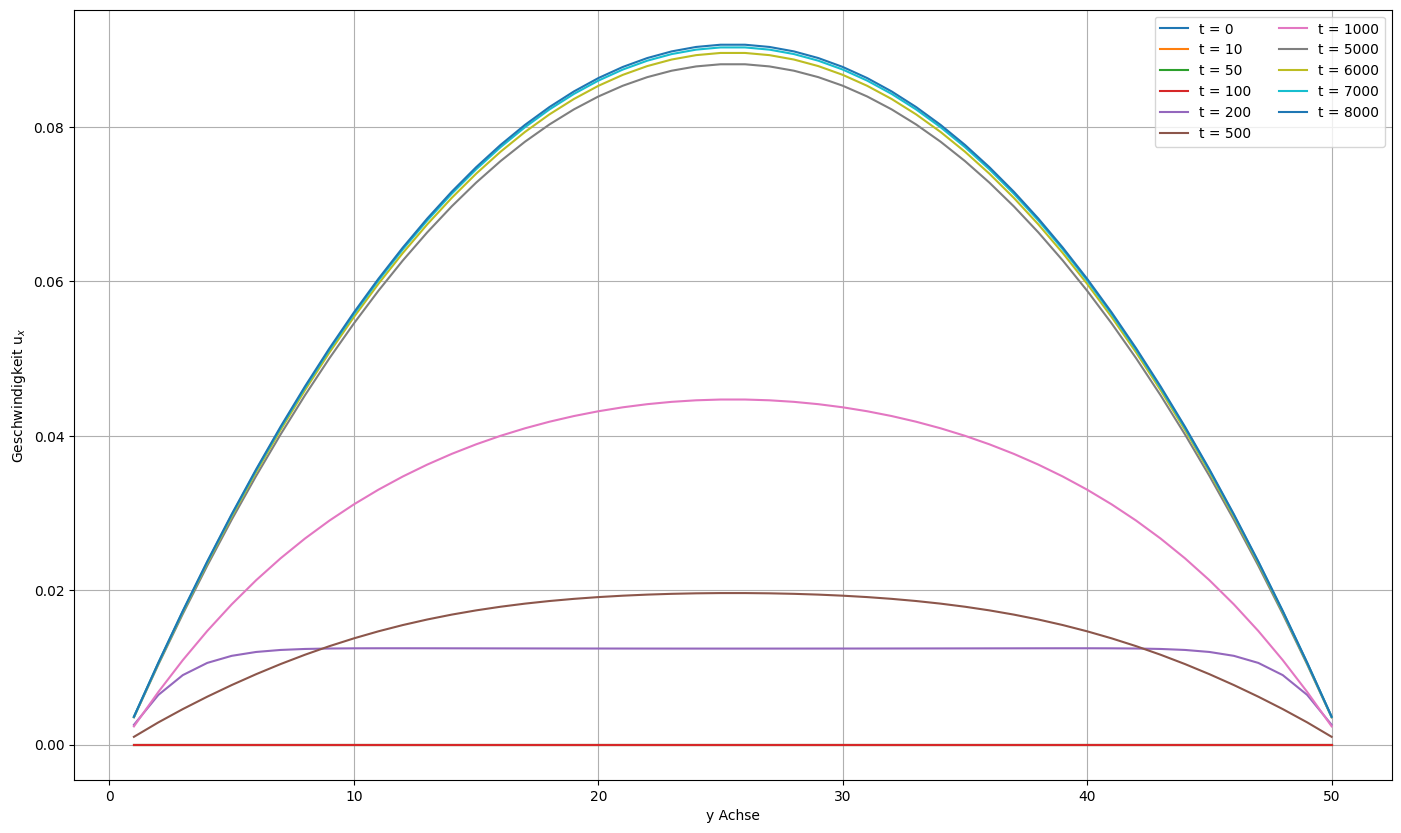

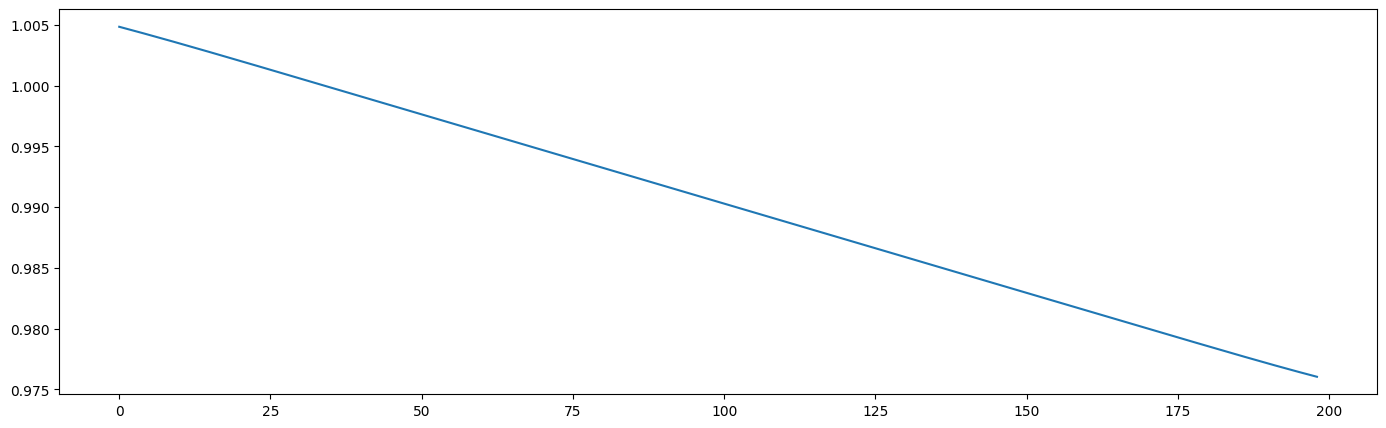

In [12]:
VERBOSE = False
TOTAL_ITERATION = 12001
start = time.perf_counter()
w = 1

while iteration < TOTAL_ITERATION:
    #1. moment update
    if iteration > 0:
        roh, u_ckl = updateMoments(pdf)
        #override the densities at 0 and N+1 using ideal gas law in isothermal ﬂuid ﬂow
        # p = cs**2 * roh 
    #enforce densities at boundary points and inlet and outlet
    #roh[:, 0] = roh_in
    #roh[:, Xn+1] = roh_out

    # Get the maximum density and its location
    max_density = np.max(roh)
    max_location = np.unravel_index(np.argmax(roh), roh.shape)
    if VERBOSE:
        if np.any(roh > 1):
            print(f"Instability detected at iteration {iteration + 1}")
        print(f"Maximum density: {max_density} at location {max_location}")


    #2. compute equilibrium
    f_eq = f_eq_3D(roh, u_ckl)

    #3. collision term
    pdf = pdf * (1 - w) + w * f_eq 
    _ltc_pre = pdf.copy()
    
    
    #4.1a Periodic Boundary conditions inlet/outlet with pressure difference
    #update extra node layers 0 and N+1 -> A) & B) acc. to Script: Boundary Conditions for the Lattice Boltzmann Method
    u_c1l = u_ckl[:, 1, :]
    u_cNl = u_ckl[:, Xn, :]    
    #u_ckl profiles at outlet and inlet
    _roh_k1 = roh[1, :]  
    _roh_kN = roh[Xn, :]    
    #assign inlet and outlet boundary values -> A)    
    fi_x0, fi_xNplus1 = calcPeriodicBC00(pdf, _roh_kN, u_cNl, roh_in_k, _roh_k1, u_c1l, roh_out_k, _ltc_pre, roh, u_ckl, iteration)
    #fi_x0, fi_xNplus1 = calcPeriodicBC1(pdf, u_ckl, roh_in_k, roh_out_k, Xn, Yn)

    #5. stream lattice 
    pdf = streamLattice0(pdf)
    #pdf = streaming(pdf)

    #4.2 Bounce-Back Top and Bottom
    #pdf = bounceBackTopBottom0(pdf, _ltc_pre, index_mapping_top, index_mapping_bottom)
    pdf = bounceBackTopBottom1(pdf, Xn, Yn)
    


    #4.1b. assign inlet boundary values -> B)
    pdf[:, 0, :] = fi_x0
    pdf[:, Xn+1, :] = fi_xNplus1

    # Update plots
    #updatePlots(iteration, pdf, u_ckl)
    #roh, u_ckl = updateMoments(pdf)
    last_den = roh
    list_streaming.append(u_ckl)

    t += dt
    iteration += 1
    #clear_output(wait=True)  # Clears the previous output
    #if (iteration % 100) == 0:
    #    print(f"Simulation Execution -> TOTAL_ITERATION: {TOTAL_ITERATION}; iteration: {iteration}; {((iteration/TOTAL_ITERATION)*100.0):.1f} %")

end = time.perf_counter()
print(f"Execution time: {end - start:.6f} seconds")

plot_multiple_frames_amplitude(list_streaming, [0, 10, 50, 100, 200, 500, 1000, 5000, 6000, 7000, 8000], (17, 10), np.arange(1, Yn + 1), "y Achse", "Geschwindigkeit u$_x$", Xn, Yn)
density_plot(last_den, Xn, Yn)

y = np.arange(0.5, Yn + 1, 1)
rho_in, rho_out, cs_2 = last_den[1, Yn // 2], last_den[Xn, Yn // 2], 1 / 3

dp = (rho_in - rho_out) * cs_2
print(f"rho_in: {rho_in}")
print(f"rho_out: {rho_out}")
print(f"dp: {dp}")